# Comparing PACE Chlorophyll Data and Trawl Data


### 1. Loading PACE Chlorophyll Data

In [9]:
import os, re
import earthaccess
import numpy as np

#### a. pull data from Earth Access

In [10]:
# choose times
temporal = ("2024-09-07", "2024-11-11")
# specific day to look at
time = np.datetime64("2024-10-20")
lat_east = slice(45, 34)     
lon_east = slice(-76, -65)   

# login to nasa
auth = earthaccess.login()

List of PACE products:

https://search.earthdata.nasa.gov/search?q=pace

Each product has a `short_name` listed in the bottom left corner. Choose the product that you want. For this project, we used 4 km chlorophyll data

In [11]:
results_day = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_MOANA",
    temporal = temporal,
    granule_name="*.DAY.*.4km.*"
)
len(results_day)

60

In [4]:
# load the data
fileset = earthaccess.open(results_day)

QUEUEING TASKS | :   0%|          | 0/60 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/60 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/60 [00:00<?, ?it/s]

In [12]:
# We need to create the dates from the fileset since the original files do not have the time
import pandas as pd
import re

# Extract dates from file paths
date_pattern = re.compile(r"PACE_OCI\.(\d{8})")

dates = []
for f in fileset:
    match = date_pattern.search(f.path)
    if not match:
        raise ValueError(f"Could not extract date from: {f.path}")
    date_str = match.group(1)
    dates.append(pd.to_datetime(date_str, format="%Y%m%d"))

# Sanity check
if len(dates) != len(fileset):
    raise ValueError(f"Mismatch: found {len(dates)} dates for {len(fileset)} files")

dates[0:3]

[Timestamp('2024-09-07 00:00:00'),
 Timestamp('2024-09-08 00:00:00'),
 Timestamp('2024-09-11 00:00:00')]

#### b. from dataset create xarray

In [13]:
import xarray as xr
CHL = xr.open_mfdataset(
    fileset,
    combine="nested",
    concat_dim="time"
)

# Overwrite with correct dates
CHL = CHL.assign_coords(time=("time", dates))
CHL_east = CHL.sel(lat=lat_east, lon=lon_east)


In [14]:
CHL

<xarray.Dataset> Size: 6GB
Dimensions:          (time: 60, lat: 3360, lon: 2640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat              (lat) float32 13kB 69.98 69.94 69.9 ... -69.9 -69.94 -69.98
  * lon              (lon) float32 11kB -84.98 -84.94 -84.9 ... 24.9 24.94 24.98
  * time             (time) datetime64[ns] 480B 2024-09-07 ... 2024-11-11
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    prococcus_moana  (time, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    syncoccus_moana  (time, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    picoeuk_moana    (time, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette          (time, rgb, eightbitcolor) uint8 46kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240907.L3m.DAY.MOANA.V3_0.4...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/MOANA/3.0
    data_bins:                         997420
    data_minimum:                      -inf
    data_maximum:                      inf

### 2. Load trawl data

data from NE Fisheries Science Center.

In [7]:
import pandas as pd

catch = pd.read_csv("towcatchdates_fall.csv", index_col=0)
catch = catch.reset_index() 
catch['lon'].min(), catch['lon'].max()

(np.float64(-75.818167), np.float64(-65.73895))

#### combine trawl data and CHL data by time, lat, lon

In [8]:
da = CHL_east["chlor_a"]   

# extract columns from catch array 
lats  = catch["lat"].to_numpy()
lons  = catch["lon"].to_numpy()
times = pd.to_datetime(catch["dates"])  

obs = xr.Dataset(
    coords={
        "obs":  np.arange(len(catch)),
        "lat":  ("obs", lats),
        "lon":  ("obs", lons),
        "time": ("obs", times),
    }
)

chl_at_trawls = da.sel(
    lat=obs["lat"], lon=obs["lon"], time=obs["time"],
    method="nearest",
    tolerance=None
)

catch["chlor_a"] = chl_at_trawls.to_numpy()


KeyError: "No variable named 'chlor_a'. Variables on the dataset include ['prococcus_moana', 'syncoccus_moana', 'picoeuk_moana', 'palette', 'lat', 'lon', 'time']"

In [ ]:
catch.head()

In [ ]:
# Ranges as plain scalars
lat_min = float(da.lat.min())
lat_max = float(da.lat.max())
lon_min = float(da.lon.min())
lon_max = float(da.lon.max())
t_min   = da.time.min().values  # numpy.datetime64
t_max   = da.time.max().values

print("CHL lat range:", lat_min, "→", lat_max)
print("CHL lon range:", lon_min, "→", lon_max)
print("CHL time range:", pd.to_datetime(t_min), "→", pd.to_datetime(t_max))

# Ensure your query arrays are NumPy
lats_np  = np.asarray(lats)
lons_np  = np.asarray(lons)
times_np = np.asarray(times.values.astype("datetime64[ns]"))

# If CHL uses 0–360 longitudes, wrap your West longitudes
if lon_min >= 0 and lon_max <= 360:
    lons_np = np.mod(lons_np, 360.0)

# Out-of-range counts
oor_lats  = ((lats_np < lat_min) | (lats_np > lat_max))
oor_lons  = ((lons_np < lon_min) | (lons_np > lon_max))
oor_times = ((times_np < t_min)  | (times_np > t_max))

print("out-of-range lats:",  int(oor_lats.sum()))
print("out-of-range lons:",  int(oor_lons.sum()))
print("out-of-range time:", int(oor_times.sum()))

# (optional) see a few offending rows
bad_idx = np.where(oor_lats | oor_lons | oor_times)[0][:10]
print("example bad rows:", bad_idx)


/tmp/ipykernel_6805/1441149486.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="lower left")


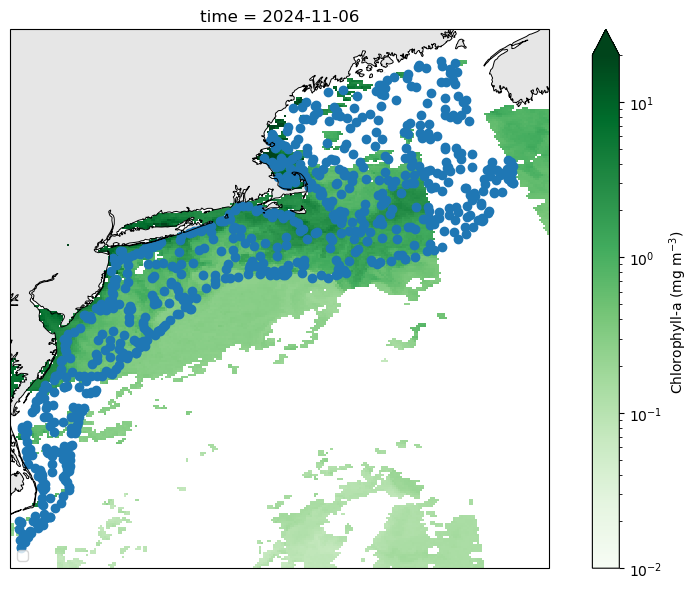

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs, cartopy.feature as cfeature

# 1) Make a DataArray (lat, lon) for the chosen time
CHL_east_plot = (
    CHL_east["chlor_a"]
    .sel(time='2024-11-06', method="nearest")
    .where(lambda x: x > 0)   # drop zeros for LogNorm
    .clip(min=0.01)           # <-- clip the DataArray, not the Dataset
)

# 2) Plot
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={"projection": ccrs.PlateCarree()})

CHL_east_plot.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap="Greens", norm=LogNorm(0.01, 20),
    cbar_kwargs={"label": "Chlorophyll-a (mg m$^{-3}$)"}
)

ax.set_extent([-76, -65, 34, 45], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="0.9")
ax.coastlines("10m", linewidth=0.7)

tol = pd.Timedelta("1D")
mask = (pd.to_datetime(catch["dates"]) >= pd.to_datetime(time) - tol) & \
       (pd.to_datetime(catch["dates"]) <= pd.to_datetime(time) + tol)

ax.scatter(catch["lon"], catch["lat"], transform=ccrs.PlateCarree())


ax.legend(loc="lower left")
plt.tight_layout()
plt.show()


lat_east = slice(45, 34)     
lon_east = slice(-76, -65)  

In [13]:
catch

,year,lat,lon,ID,dates,surf_temp,bot_temp,surf_salinity,bot_salinity,avg_depth,region,chlor_a
0,2023,39.023500,-73.294333,202304017400040014,2023-09-10,24.62,9.93,31.693,33.049,70.0,northeast,NaN
1,2023,38.840500,-73.203333,202304017400020015,2023-09-10,25.49,10.00,31.953,33.350,81.0,northeast,NaN
2,2023,38.844167,-72.988167,202304017500020016,2023-09-10,24.92,14.05,33.659,35.459,118.0,northeast,NaN
3,2023,38.851833,-72.934000,202304017600040017,2023-09-10,25.47,13.28,33.237,35.600,192.0,northeast,NaN
4,2023,38.852333,-72.933667,202304017600010018,2023-09-10,25.47,13.28,33.237,35.600,190.0,northeast,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
754,2024,42.111695,-70.044550,202404036100030808,2024-11-10,11.47,9.74,32.323,32.696,50.0,northeast,1.932778
755,2024,42.137878,-70.016288,202404012600020810,2024-11-10,11.44,8.08,32.405,33.121,88.0,northeast,0.967306
756,2024,42.355163,-70.252827,202404012600040812,2024-11-11,11.41,11.18,32.239,32.333,40.0,northeast,NaN
757,2024,42.287042,-70.368130,202404012600060814,2024-11-11,12.00,10.40,32.005,32.383,89.0,northeast,0.894910


for this data i want to put it into a spatial mesh grid so I can run a model into it. What is the best way to do this with this lat lon data. I typically would use np.meshgrid but am unfamiliar with how to do this with georeferenced data. 

In [ ]:
from pyproj import Transformer

# ---- SETTINGS ----
EPSG_LL = 4326          # lon/lat
EPSG_UTM10 = 32610      # WGS84 / UTM zone 10N  (use 26910 if NAD83)
dx = dy = 4000.0        # 4 km grid
buffer_m = 2000.0      

# ---- 0) Clean/normalize dates (fixes TypeError from mixed types) ----
# Coerce to datetime; send unparseable to NaT; drop tz and normalize to midnight
dates = pd.to_datetime(catch["dates"], errors="coerce", utc=True)
if getattr(dates.dt, "tz", None) is not None:
    dates = dates.dt.tz_convert(None)
catch = catch.assign(date=dates.dt.normalize()).dropna(subset=["date"])

# ---- CHL DataArray if you want satellite on the same grid/time later (optional) ----
da = CHL_east["chlor_a"]
if "latitude" in da.coords: 
    da = da.rename(latitude="lat")
if "longitude" in da.coords: 
    da = da.rename(longitude="lon")
da = da.sortby(["time", "lat", "lon"])

# ---- 1) Project catch to UTM10 ----
to_xy = Transformer.from_crs(EPSG_LL, EPSG_UTM10, always_xy=True).transform
to_ll = Transformer.from_crs(EPSG_UTM10, EPSG_LL, always_xy=True).transform

Xc, Yc = to_xy(catch["lon"].to_numpy(), catch["lat"].to_numpy())
catch["X"] = Xc
catch["Y"] = Yc

# ---- 2) Build a 4-km grid covering ALL catch points ----
xmin = np.floor((catch["X"].min() - buffer_m) / dx) * dx
xmax = np.ceil((catch["X"].max() + buffer_m) / dx) * dx
ymin = np.floor((catch["Y"].min() - buffer_m) / dy) * dy
ymax = np.ceil((catch["Y"].max() + buffer_m) / dy) * dy

x_edges = np.arange(xmin, xmax + dx, dx)
y_edges = np.arange(ymin, ymax + dy, dy)
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
nx, ny = len(x_centers), len(y_centers)

X2d, Y2d = np.meshgrid(x_centers, y_centers)   # meters (UTM10)
LON2d, LAT2d = to_ll(X2d, Y2d)                 # for reference/plots

# ---- 3) Time axis: ALL unique times in catch ----
time_union = pd.DatetimeIndex(sorted(catch["date"].unique()))

# ---- 4) Aggregate catch into grid cells per time ----
ix = np.searchsorted(x_edges, catch["X"].values, side="right") - 1
iy = np.searchsorted(y_edges, catch["Y"].values, side="right") - 1
inside = (ix >= 0) & (ix < nx) & (iy >= 0) & (iy < ny)

df = catch.loc[inside, ["date", "chlor_a"]].copy()
df["ix"] = ix[inside]
df["iy"] = iy[inside]

agg = df.groupby(["date", "iy", "ix"]).agg(
    chl_mean=("chlor_a", "mean"),
    n_obs=("chlor_a", "size"),
).reset_index()

# map each timestamp to an integer index
t_index = pd.Series(np.arange(len(time_union)), index=time_union)
agg["t_index"] = agg["date"].map(t_index)

# allocate grids and scatter in the aggregated values
chl_grid = np.full((len(time_union), ny, nx), np.nan, dtype=float)
nobs_grid = np.zeros((len(time_union), ny, nx), dtype=int)
chl_grid[agg["t_index"], agg["iy"], agg["ix"]] = agg["chl_mean"].to_numpy()
nobs_grid[agg["t_index"], agg["iy"], agg["ix"]] = agg["n_obs"].to_numpy()

grid = xr.Dataset(
    coords={"time": time_union, "y": np.arange(ny), "x": np.arange(nx)},
    data_vars={
        "X": (("y","x"), X2d),
        "Y": (("y","x"), Y2d),
        "lon": (("y","x"), LON2d),
        "lat": (("y","x"), LAT2d),
        "chlor_a_catch": (("time","y","x"), chl_grid),
        "n_obs": (("time","y","x"), nobs_grid),
    },
    attrs={"crs": f"EPSG:{EPSG_UTM10}", "cellsize_m": dx},
)

# ---- 5) (Optional) Put satellite CHL on SAME grid/time ----
# If CHL longitudes are 0–360, wrap our grid longitudes before interp:
lon_for_interp = LON2d
try:
    lon_min = float(da.lon.min())
    lon_max = float(da.lon.max())
    if (lon_min >= 0.0) and (lon_max <= 360.0):
        lon_for_interp = np.mod(lon_for_interp, 360.0)
except Exception:
    pass  # be forgiving if lon min/max isn't readily computed (e.g., lazy/dask)

chl_sat_xy = da.interp(time=time_union, method="nearest").interp(
    lat=(("y","x"), LAT2d),
    lon=(("y","x"), lon_for_interp),
    method="nearest",
)

chl_sat_xy = chl_sat_xy.rename("chlor_a_sat").reset_coords(("lat","lon"), drop=True)
grid["chlor_a_sat"] = chl_sat_xy

# ---- 6) Tidy table for sdmTMB / export ----
df_grid = grid[["X","Y","chlor_a_catch","n_obs","chlor_a_sat"]].to_dataframe().reset_index()

# Example export:
# df_grid.to_parquet("grid_4km_spacetime_utm10.parquet")
# df_grid.to_csv("grid_4km_spacetime_utm10.csv", index=False)


In [28]:
df_grid

,y,x,time,X,Y,chlor_a_catch,n_obs,chlor_a_sat
0,0,0,2023-05-09,4698000.0,5014000.0,NaN,0,NaN
1,0,0,2023-05-10,4698000.0,5014000.0,NaN,0,NaN
2,0,0,2023-05-11,4698000.0,5014000.0,NaN,0,NaN
3,0,0,2023-05-12,4698000.0,5014000.0,NaN,0,NaN
4,0,0,2023-05-13,4698000.0,5014000.0,NaN,0,NaN
...,...,...,...,...,...,...,...,...
3816985,421,134,2024-05-09,5234000.0,6698000.0,NaN,0,NaN
3816986,421,134,2024-05-10,5234000.0,6698000.0,NaN,0,NaN
3816987,421,134,2024-05-11,5234000.0,6698000.0,NaN,0,NaN
3816988,421,134,2024-05-12,5234000.0,6698000.0,NaN,0,NaN


In [19]:
test_grid_20240824 = df_grid[df_grid['time'] == '2024-08-24']
test_grid_20240824.to_csv('test_grid_20240824', index=False)

In [16]:
catch

,latitude_dd,longitude_dd,Trawl_id,date_formatted,datetime_utc_iso,dates,chlor_a,X,Y
0,38.674167,-123.765556,202403020103,2024-Jun-19,2024-06-19T00:00:00Z,2024-06-19,NaN,433405.800231,4.280898e+06
1,42.773611,-124.739167,202403017075,2024-Sep-06,2024-09-06T00:00:00Z,2024-09-06,NaN,357722.332181,4.737142e+06
2,41.179167,-124.806944,202403020088,2024-Jun-16,2024-06-16T00:00:00Z,2024-06-16,NaN,348442.072195,4.560220e+06
3,47.271667,-124.672500,202403017029,2024-Aug-24,2024-08-24T00:00:00Z,2024-08-24,1.220879,373494.564291,5.236711e+06
4,34.083333,-120.196944,202403008151,2024-Jun-30,2024-06-30T00:00:00Z,2024-06-30,NaN,758641.729081,3.774943e+06
...,...,...,...,...,...,...,...,...,...
651,34.283611,-120.208889,202403010131,2024-Oct-03,2024-10-03T00:00:00Z,2024-10-03,NaN,756930.715621,3.797130e+06
652,47.541389,-124.895556,202403010017,2024-Aug-21,2024-08-21T00:00:00Z,2024-08-21,NaN,357353.717926,5.267071e+06
653,45.090833,-124.704722,202403010005,2024-Aug-18,2024-08-18T00:00:00Z,2024-08-18,NaN,365854.303329,4.994454e+06
654,34.228056,-119.466944,202403020156,2024-Jul-05,2024-07-05T00:00:00Z,2024-07-05,0.590787,825471.832857,3.793092e+06
